# CS675 Introduction to Data Science - Project #3

**Aayushi Verma**

The aim of this project is to perform time series forecasting for New York City's electric consumption for its 5 boroughs. We use the FB Prophet package to perform most of the analysis in this project.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import datetime as dt
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from dask.distributed import Client
import itertools

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step One: Inspecting and Cleaning the Data

This dataset is obtained from: https://data.cityofnewyork.us/Housing-Development/Electric-Consumption-And-Cost-2010-Feb-2022-/jr24-e7cr. It details the monthly consumption and cost data by the 5 boroughs of New York.

In [2]:
raw = pd.read_csv("data.csv")

/var/folders/n9/3mjn__fd1xd66lc1zh9nlj0h0000gp/T/ipykernel_41347/2433355955.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv("data.csv")


In [3]:
raw.head()

,Development Name,Borough,Account Name,Location,Meter AMR,Meter Scope,TDS #,EDP,RC Code,Funding Source,...,Meter Number,Estimated,Current Charges,Rate Class,Bill Analyzed,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges
0,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,15396.82,GOV/NYC/068,Yes,128800,7387.97,216.0,2808.0,5200.85
1,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14556.34,GOV/NYC/068,Yes,115200,6607.87,224.0,2912.0,5036.47
2,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13904.98,GOV/NYC/068,Yes,103200,5919.55,216.0,2808.0,5177.43
3,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14764.04,GOV/NYC/068,Yes,105600,6057.22,208.0,2704.0,6002.82
4,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13729.54,GOV/NYC/068,Yes,97600,5598.34,216.0,2808.0,5323.20


In [4]:
raw['Consumption (KWH)'].describe()

count    4.070310e+05
mean     3.142596e+04
std      4.927138e+04
min      0.000000e+00
25%      0.000000e+00
50%      1.400000e+04
75%      4.640000e+04
max      1.779600e+06
Name: Consumption (KWH), dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x13e077910>,
 'caps': [<matplotlib.lines.Line2D at 0x13e077eb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x13e077640>],
 'medians': [<matplotlib.lines.Line2D at 0x13e0c0490>],
 'fliers': [<matplotlib.lines.Line2D at 0x13e0c0760>],
 'means': []}

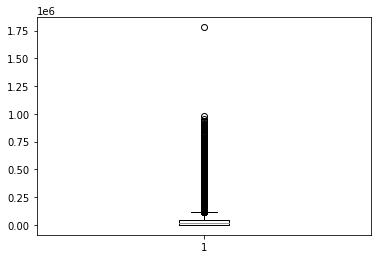

In [5]:
plt.boxplot(raw['Consumption (KWH)'])

In [6]:
raw.shape

(407031, 27)

In [7]:
raw.isnull().sum()

Development Name        1086
Borough                    0
Account Name               0
Location               10625
Meter AMR                186
Meter Scope           385539
TDS #                   2343
EDP                        0
RC Code                    0
Funding Source             0
AMP #                   1886
Vendor Name                0
UMIS BILL ID               0
Revenue Month              0
Service Start Date         8
Service End Date           8
# days                     8
Meter Number               0
Estimated                342
Current Charges            0
Rate Class                 0
Bill Analyzed              0
Consumption (KWH)          0
KWH Charges                0
Consumption (KW)           0
KW Charges                 0
Other charges              0
dtype: int64

In [8]:
df = raw.dropna()
df.isnull().sum()

Development Name      0
Borough               0
Account Name          0
Location              0
Meter AMR             0
Meter Scope           0
TDS #                 0
EDP                   0
RC Code               0
Funding Source        0
AMP #                 0
Vendor Name           0
UMIS BILL ID          0
Revenue Month         0
Service Start Date    0
Service End Date      0
# days                0
Meter Number          0
Estimated             0
Current Charges       0
Rate Class            0
Bill Analyzed         0
Consumption (KWH)     0
KWH Charges           0
Consumption (KW)      0
KW Charges            0
Other charges         0
dtype: int64

In [9]:
df.shape

(21049, 27)

Now that we have cleaned the data, the next step is to consider the data columns we will be using. We are interested in forecasting the electricity consumption of NYC's boroughs over time. So we need a column with dates, a column with energy consumption, and a column for the boroughs. Inspecting the ```df.head()``` we looked at earlier, we see that there are a few date-like columns, and 2 different columns that measure electricity consumption. I have detailed my choices as below:
- Date column: I will use ```Service End Date``` as the date column, since it has dates granular to the date level, instead of e.g. months or years. This will allow for better forecasting because of more data points.
- Energy consumption column: I will use ```Consumption (KWH)``` to measure electricity consumption instead of ```Consumption (KW)```, since kW is a measure of the *rate* of energy used, not the consumption.

Therefore, we will now convert the dataframe to allow these columns only, and further clean up the data by changing data types.

In [10]:
df['Service End Date'] = pd.to_datetime(df['Service End Date'])
df = df.rename(columns={'Service End Date':'ds','Consumption (KWH)':'y'})
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day

/var/folders/n9/3mjn__fd1xd66lc1zh9nlj0h0000gp/T/ipykernel_41347/2313118396.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Service End Date'] = pd.to_datetime(df['Service End Date'])


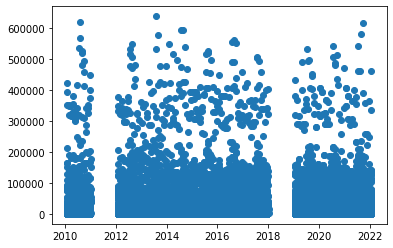

In [11]:
plt.scatter(df['ds'],df['y'])

{'whiskers': [<matplotlib.lines.Line2D at 0x13e428c10>,
 'caps': [<matplotlib.lines.Line2D at 0x13e4291b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x13e428940>],
 'medians': [<matplotlib.lines.Line2D at 0x13e429750>],
 'fliers': [<matplotlib.lines.Line2D at 0x13e429a20>],
 'means': []}

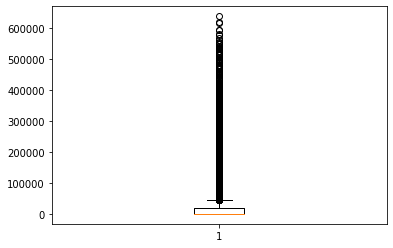

In [12]:
plt.boxplot(df['y'])

In [13]:
df2 = df.copy()
df2.head()

,Development Name,Borough,Account Name,Location,Meter AMR,Meter Scope,TDS #,EDP,RC Code,Funding Source,...,Rate Class,Bill Analyzed,y,KWH Charges,Consumption (KW),KW Charges,Other charges,year,month,day
0,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,GOV/NYC/068,Yes,128800,7387.97,216.0,2808.0,5200.85,2010,1,26
1,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,GOV/NYC/068,Yes,115200,6607.87,224.0,2912.0,5036.47,2010,2,25
2,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,GOV/NYC/068,Yes,103200,5919.55,216.0,2808.0,5177.43,2010,3,26
3,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,GOV/NYC/068,Yes,105600,6057.22,208.0,2704.0,6002.82,2010,4,26
4,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,GOV/NYC/068,Yes,97600,5598.34,216.0,2808.0,5323.20,2010,5,24


In [14]:
df2['avg_by_year'] = df2.groupby('year')['y'].transform('mean')
df2['avg_by_month'] = df2.groupby('month')['y'].transform('mean')
df2['avg_by_day'] = df2.groupby('ds')['y'].transform('mean')
df2 = df2[['ds','avg_by_year','avg_by_month','avg_by_day','Borough']]

In [15]:
df2.tail()

,ds,avg_by_year,avg_by_month,avg_by_day,Borough
406348,2021-09-22,22024.948729,27689.402915,20094.051948,BROOKLYN
406349,2021-10-22,22024.948729,20610.027879,15564.709677,BROOKLYN
406350,2021-11-22,22024.948729,19682.643247,12786.664430,BROOKLYN
406351,2021-12-23,22024.948729,21726.996966,13981.832215,BROOKLYN
406352,2022-01-25,22359.887574,22514.689847,15447.195946,BROOKLYN


In [16]:
df_by_year = df2.rename(columns={'avg_by_year':'y'})[['ds','y','Borough']].dropna().reset_index(drop=True)
df_by_month = df2.rename(columns={'avg_by_month':'y'})[['ds','y','Borough']].dropna().reset_index(drop=True)
df_by_day = df2.rename(columns={'avg_by_day':'y'})[['ds','y','Borough']].dropna().reset_index(drop=True)

In [17]:
df_by_year.tail()

,ds,y,Borough
21044,2021-09-22,22024.948729,BROOKLYN
21045,2021-10-22,22024.948729,BROOKLYN
21046,2021-11-22,22024.948729,BROOKLYN
21047,2021-12-23,22024.948729,BROOKLYN
21048,2022-01-25,22359.887574,BROOKLYN


In [18]:
df_by_year['y'].describe()

count     21049.000000
mean      22954.689962
std        1220.517007
min        7746.666667
25%       22359.887574
50%       22925.097200
75%       23924.659259
max      150980.000000
Name: y, dtype: float64

In [19]:
df_by_month['y'].describe()

count    21049.000000
mean     22954.689962
std       3863.489015
min      19682.643247
25%      19929.905154
50%      20610.027879
75%      23232.728824
max      31182.732240
Name: y, dtype: float64

In [20]:
df_by_day['y'].describe()

count     21049.000000
mean      22954.689962
std       27475.572963
min           0.000000
25%       14101.791946
50%       16487.845912
75%       20936.621302
max      542000.000000
Name: y, dtype: float64

<AxesSubplot:ylabel='Count'>

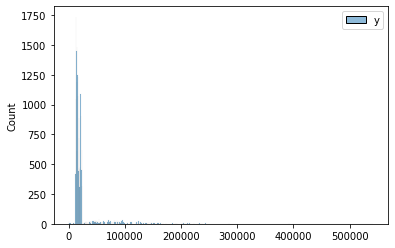

In [21]:
sns.histplot(df_by_day)

{'whiskers': [<matplotlib.lines.Line2D at 0x13edc9cc0>,
 'caps': [<matplotlib.lines.Line2D at 0x13edca260>,
 'boxes': [<matplotlib.lines.Line2D at 0x13edc9b10>],
 'medians': [<matplotlib.lines.Line2D at 0x13edca800>],
 'fliers': [<matplotlib.lines.Line2D at 0x13edcaad0>],
 'means': []}

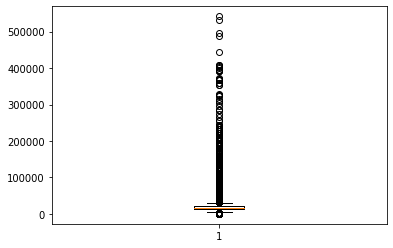

In [22]:
plt.boxplot(df_by_day['y'])

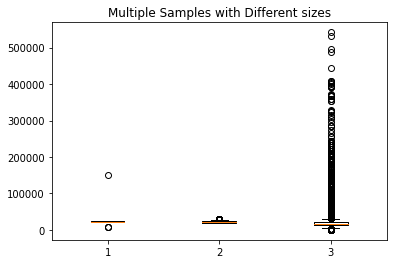

In [23]:
data = [df_by_year['y'], df_by_month['y'], df_by_day['y']]
fig, ax = plt.subplots()
ax.set_title('Multiple Samples with Different sizes')
ax.boxplot(data)

plt.show()

In [24]:
def plot_data_check(df):
    plt.scatter(df['ds'],df['y'])
    plt.axhline(df['y'].mean(),color="red")

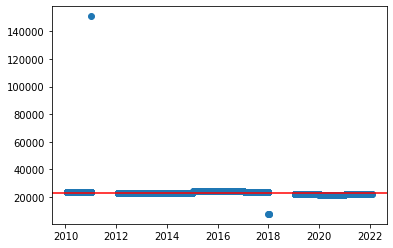

In [25]:
plot_data_check(df_by_year)

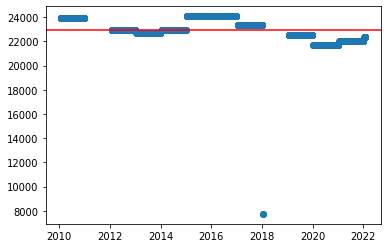

In [26]:
df_by_year = df_by_year.drop(index=[df_by_year[df_by_year['y']==df_by_year['y'].min()].index[0]], axis=0)
df_by_year = df_by_year.drop(index=[df_by_year[df_by_year['y']==df_by_year['y'].max()].index[0]], axis=0)
plot_data_check(df_by_year)

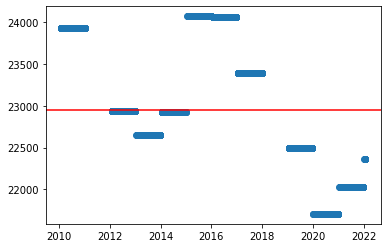

In [27]:
df_by_year = df_by_year.drop(index=[df_by_year[df_by_year['y']==df_by_year['y'].min()].index[0]], axis=0)
df_by_year = df_by_year.drop(index=[df_by_year[df_by_year['y']==df_by_year['y'].min()].index[0]], axis=0)
plot_data_check(df_by_year)

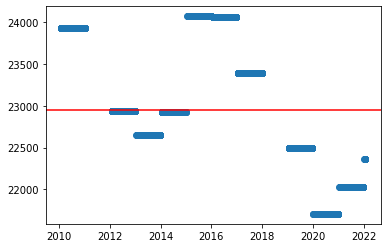

In [28]:
plot_data_check(df_by_year)

## Step Two: Fitting Model

In [29]:
def future_preds(df,period):
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(period) #period is in units of days
    forecast = m.predict(future)
    fig1 = m.plot(forecast);
    fig2 = m.plot_components(forecast);
    return (m, future, forecast, fig1, fig2)

In [30]:
df_by_year.isnull().sum() #df_by_month #

ds         0
y          0
Borough    0
dtype: int64

### By Year

In [31]:
m = Prophet()
m.fit(df_by_year)
future = m.make_future_dataframe(365) #period is in units of days
forecast = m.predict(future)

11:25:21 - cmdstanpy - INFO - Chain [1] start processing
11:26:05 - cmdstanpy - INFO - Chain [1] done processing


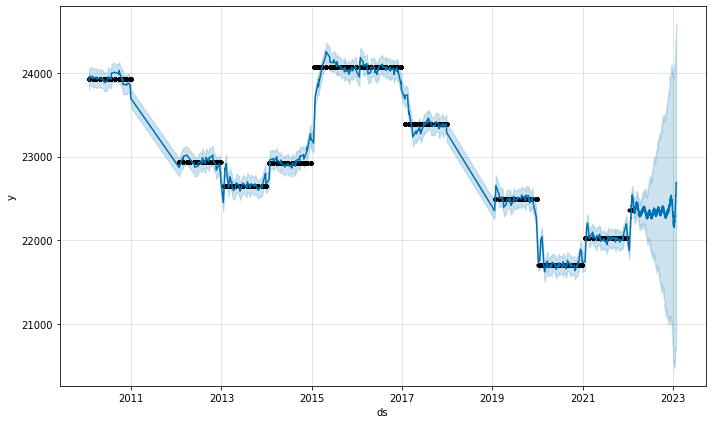

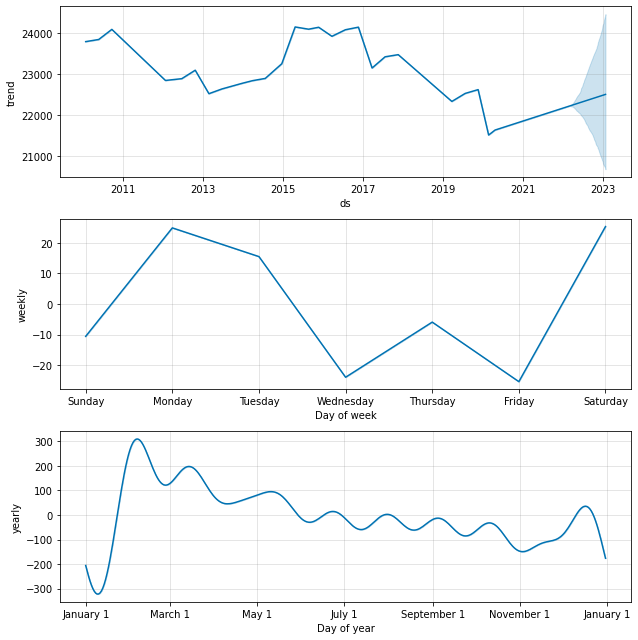

In [32]:
fig1 = m.plot(forecast);
fig2 = m.plot_components(forecast);

11:26:07 - cmdstanpy - INFO - Chain [1] start processing
11:26:50 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
829,2023-01-24,22538.235695,20713.682143,24527.497256
830,2023-01-25,22536.356055,20690.802542,24462.209480
831,2023-01-26,22591.083048,20739.808882,24568.278572
832,2023-01-27,22606.857201,20758.011374,24565.543340
833,2023-01-28,22690.973024,20845.765170,24672.815463


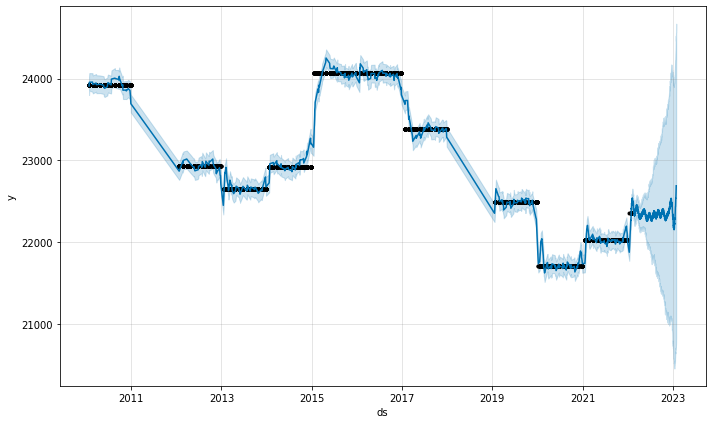

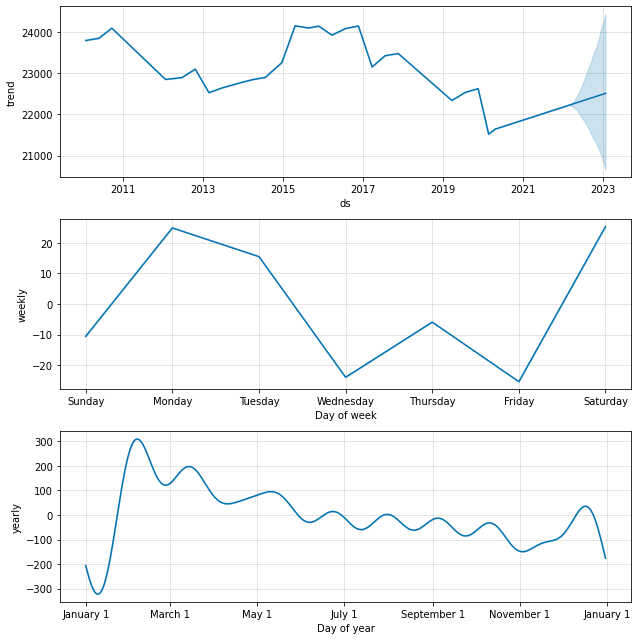

In [33]:
m_by_1_year, future_by_1_year, forecast_for_1_year, fig1, fig2 = future_preds(df_by_year,period=365)
forecast_for_1_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

11:26:52 - cmdstanpy - INFO - Chain [1] start processing
11:27:34 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
4114,2032-01-22,25263.666458,-44440.002570,93988.243289
4115,2032-01-23,25281.900376,-44435.562463,94156.477819
4116,2032-01-24,25370.660565,-44358.784916,94312.377730
4117,2032-01-25,25372.478145,-44370.431471,94292.517166
4118,2032-01-26,25444.937611,-44193.397165,94333.173548


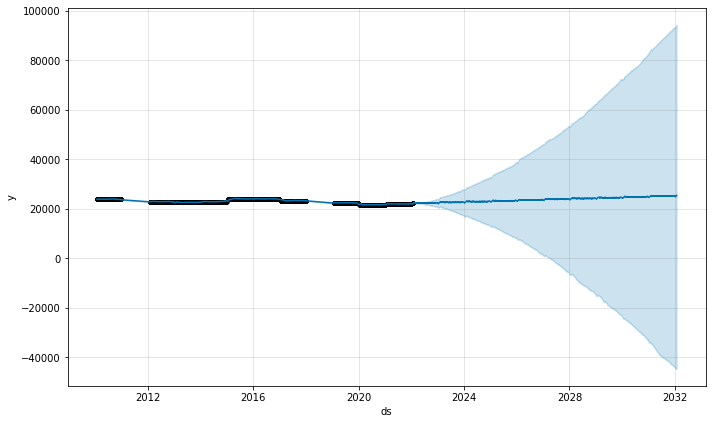

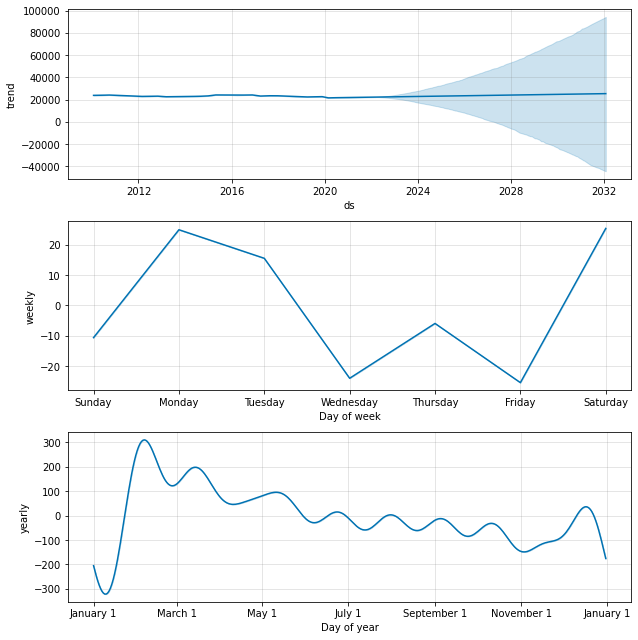

In [34]:
m_by_10_year, future_by_10_year, forecast_for_10_year, fig1, fig2 = future_preds(df_by_year,period=10*365)
forecast_for_10_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

11:27:37 - cmdstanpy - INFO - Chain [1] start processing
11:28:18 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
7764,2042-01-19,28316.265015,-178181.058841,216054.191901
7765,2042-01-20,28386.405674,-178128.032935,216181.748826
7766,2042-01-21,28413.273826,-178053.752114,216365.896137
7767,2042-01-22,28411.159977,-178267.337255,216320.900989
7768,2042-01-23,28467.134468,-178111.123193,216526.164674


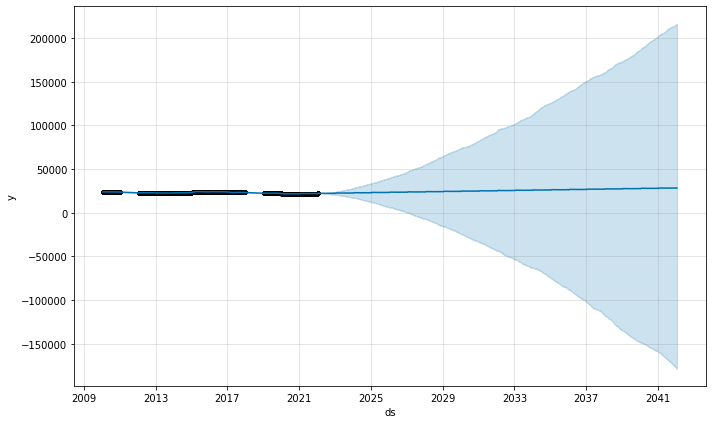

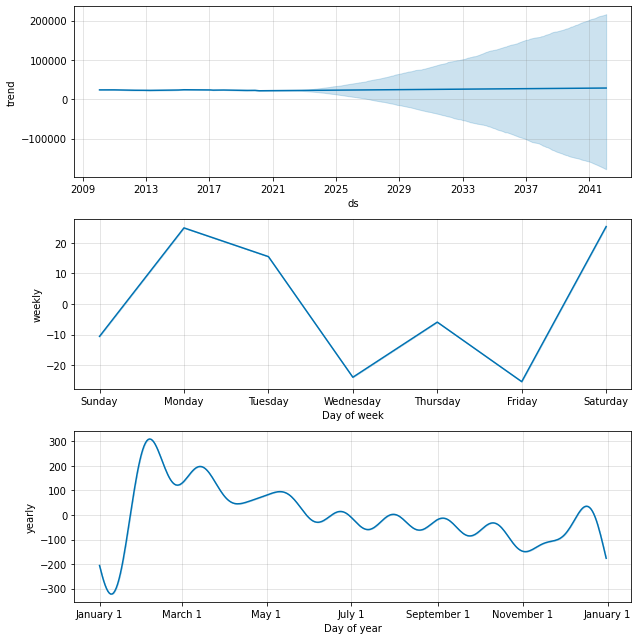

In [35]:
m_by_20_year, future_by_20_year, forecast_for_20_year, fig1, fig2 = future_preds(df_by_year,period=20*365)
forecast_for_20_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

### By Month

11:28:22 - cmdstanpy - INFO - Chain [1] start processing
11:28:36 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
497,2022-02-23,20365.942863,20209.629198,20520.590129
498,2022-02-24,20345.189409,20187.791422,20494.390966
499,2022-02-25,20307.778224,20150.494752,20474.625076
500,2022-02-26,20415.983553,20252.797947,20575.217698
501,2022-02-27,20312.124029,20152.828567,20460.428435


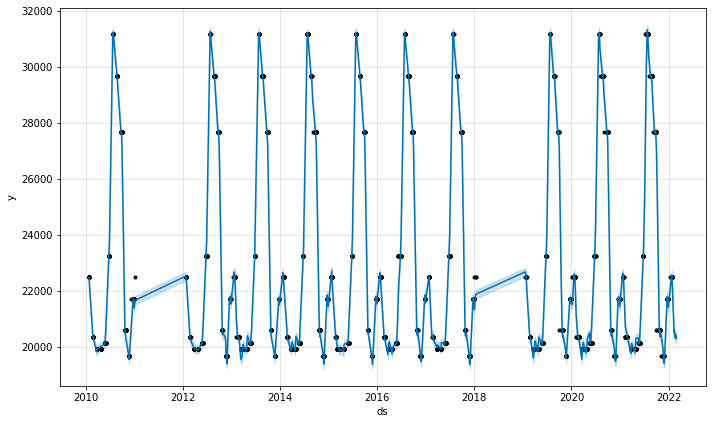

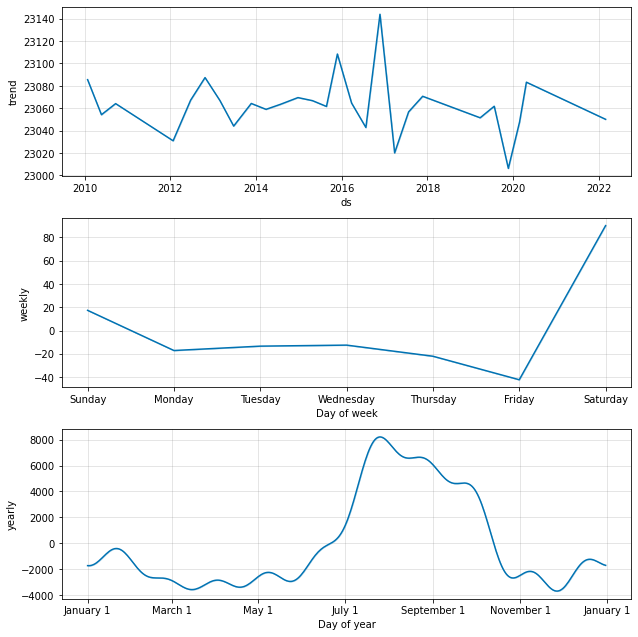

In [36]:
m_by_1_month, future_by_1_month, forecast_for_1_month, fig1, fig2 = future_preds(df_by_month,period=30)
forecast_for_1_month[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

11:28:38 - cmdstanpy - INFO - Chain [1] start processing
11:28:51 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
647,2022-07-23,31214.306771,31034.251991,31381.887287
648,2022-07-24,31215.807492,31032.961560,31383.783948
649,2022-07-25,31221.429085,31043.921973,31390.508920
650,2022-07-26,31233.053459,31063.510983,31398.200155
651,2022-07-27,31212.021925,31020.098184,31379.229879


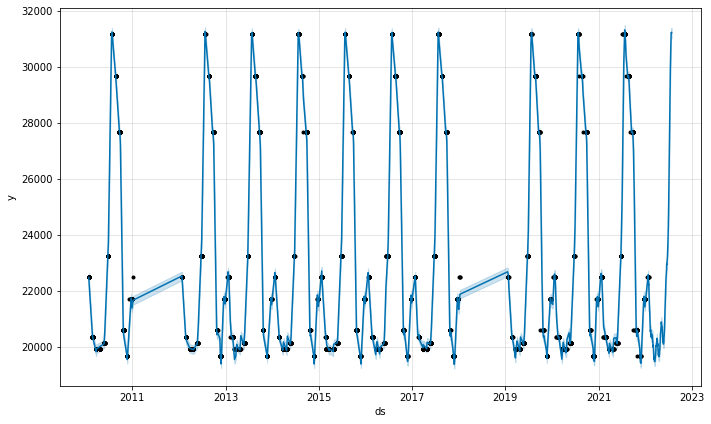

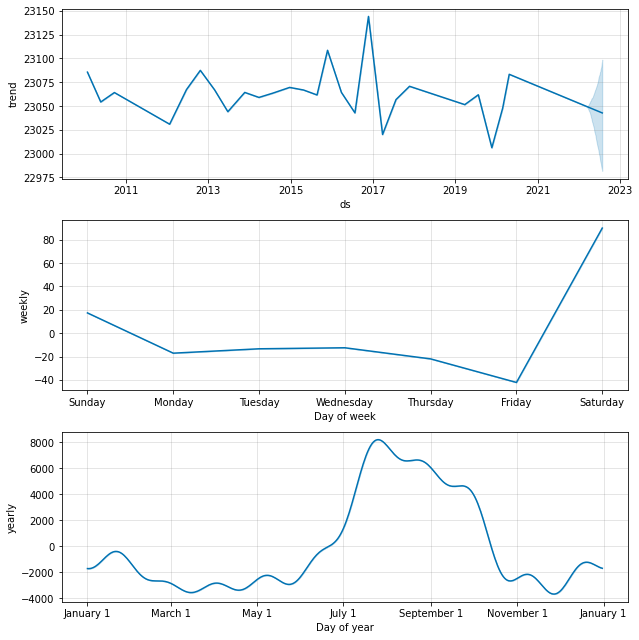

In [37]:
m_by_6_month, future_by_6_month, forecast_for_6_month, fig1, fig2 = future_preds(df_by_month,period=30*6)
forecast_for_6_month[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

11:28:53 - cmdstanpy - INFO - Chain [1] start processing
11:29:05 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
737,2022-10-21,20871.664307,20671.599172,21071.733350
738,2022-10-22,20835.663154,20639.268726,21037.957492
739,2022-10-23,20627.440276,20425.152232,20832.497168
740,2022-10-24,20489.504727,20299.683244,20689.940553
741,2022-10-25,20420.632327,20224.198146,20617.582783


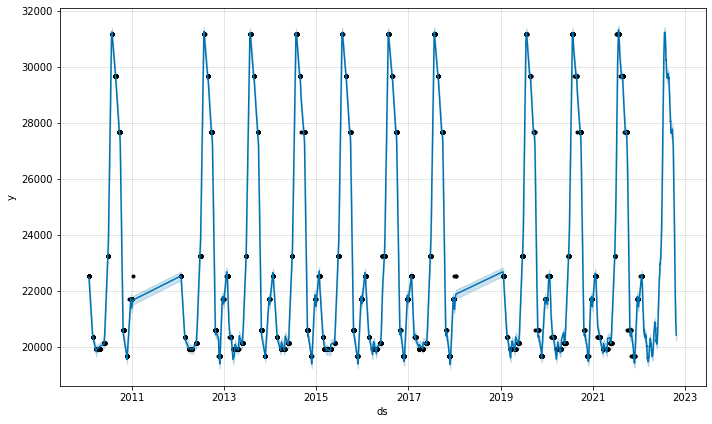

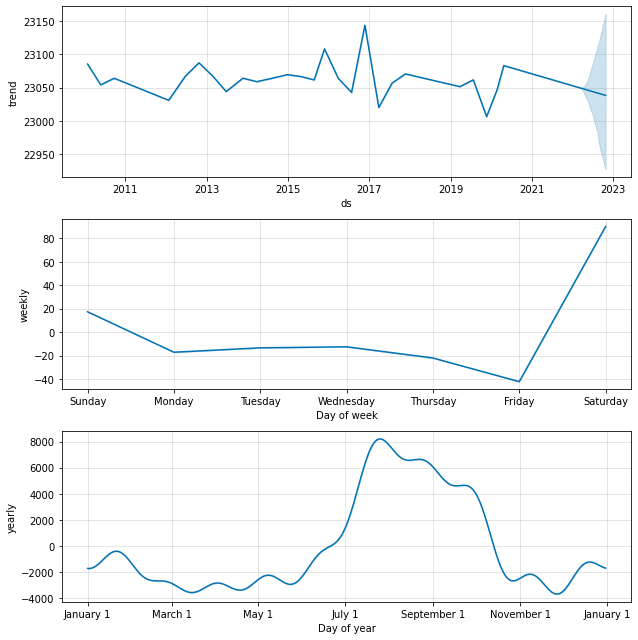

In [38]:
m_by_9_month, future_by_9_month, forecast_for_9_month, fig1, fig2 = future_preds(df_by_month,period=30*9)
forecast_for_9_month[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

### By Day

11:29:07 - cmdstanpy - INFO - Chain [1] start processing
11:29:09 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
567,2022-05-04,35539.880944,2388.465134,69921.990887
568,2022-05-05,34489.622840,75.615312,68684.713992
569,2022-05-06,33326.493610,-1175.778946,70846.709528
570,2022-05-07,102007.067052,70381.848107,135117.925890
571,2022-05-08,103205.664946,71308.046396,136520.218024


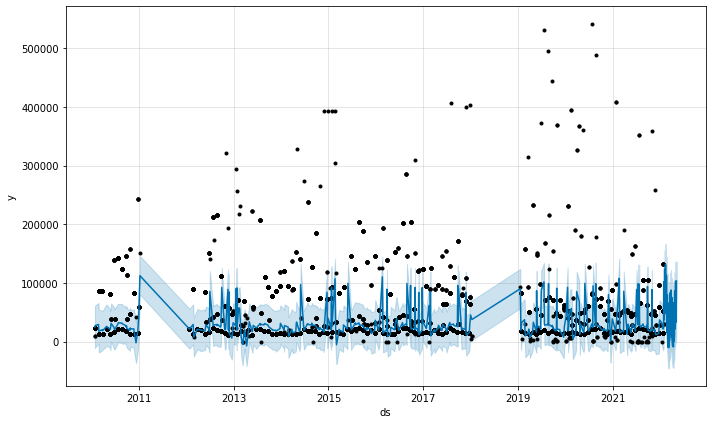

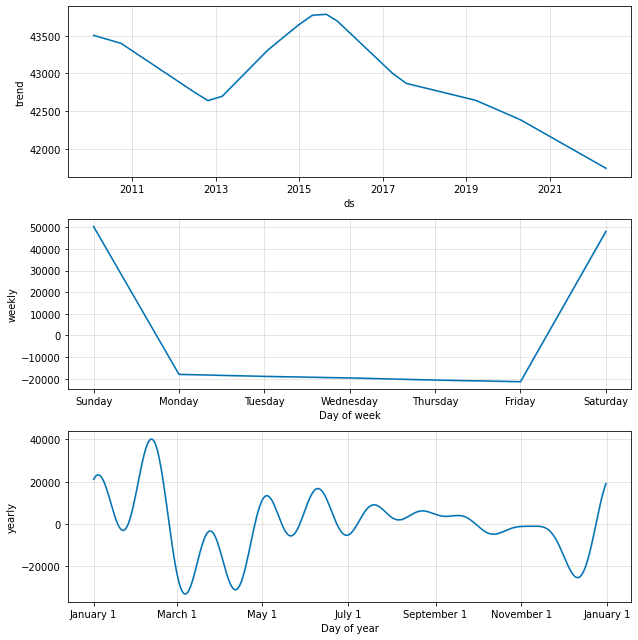

In [39]:
m_by_100_day, future_by_100_day, forecast_for_100_day, fig1, fig2 = future_preds(df_by_day,period=100)
forecast_for_100_day[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

11:29:11 - cmdstanpy - INFO - Chain [1] start processing
11:29:12 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
667,2022-08-12,23603.622780,-7959.333841,57147.794929
668,2022-08-13,93416.701776,56752.435455,124511.080338
669,2022-08-14,96050.486179,63081.831930,127498.292806
670,2022-08-15,28154.553591,-4515.938712,58534.379611
671,2022-08-16,27601.463280,-5791.851573,61814.055990


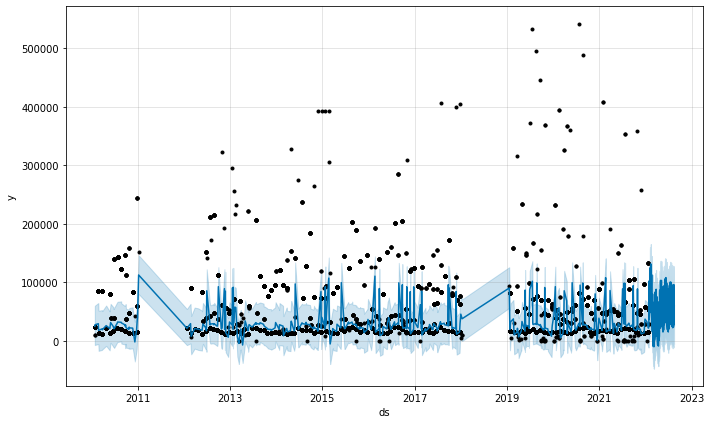

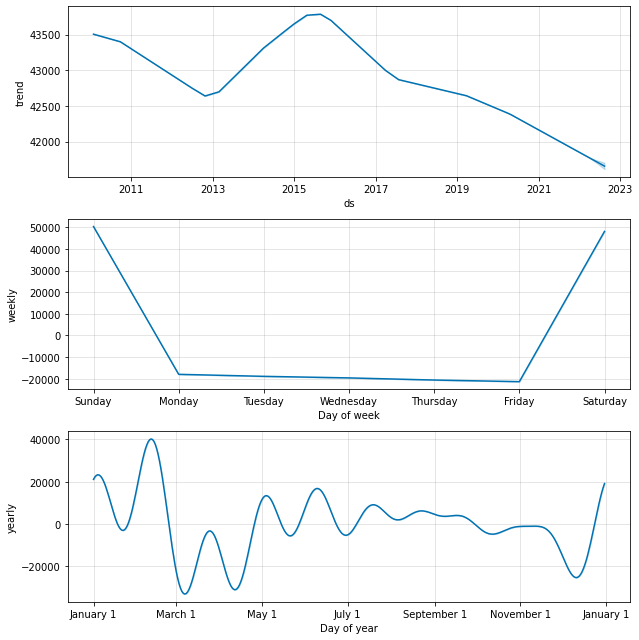

In [40]:
m_by_200_day, future_by_200_day, forecast_for_200_day, fig1, fig2 = future_preds(df_by_day,period=200)
forecast_for_200_day[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

11:29:14 - cmdstanpy - INFO - Chain [1] start processing
11:29:16 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
832,2023-01-24,20195.706272,-13362.243528,53759.200801
833,2023-01-25,20426.349859,-12923.755378,54339.689161
834,2023-01-26,20840.155361,-14485.858622,55047.963177
835,2023-01-27,21928.925796,-13981.337660,56632.225176
836,2023-01-28,93585.962810,60487.146762,126010.569755


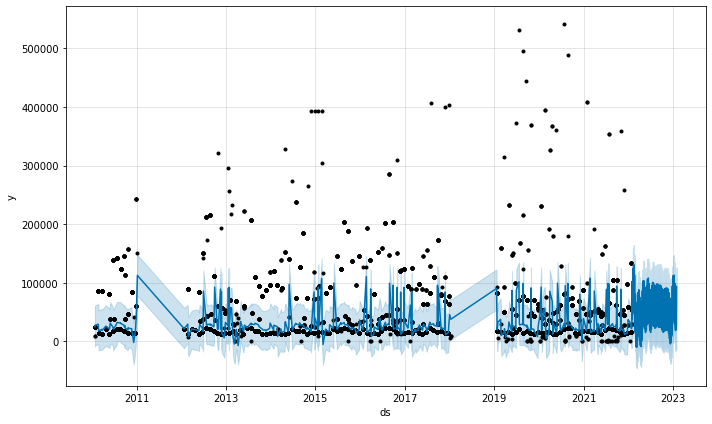

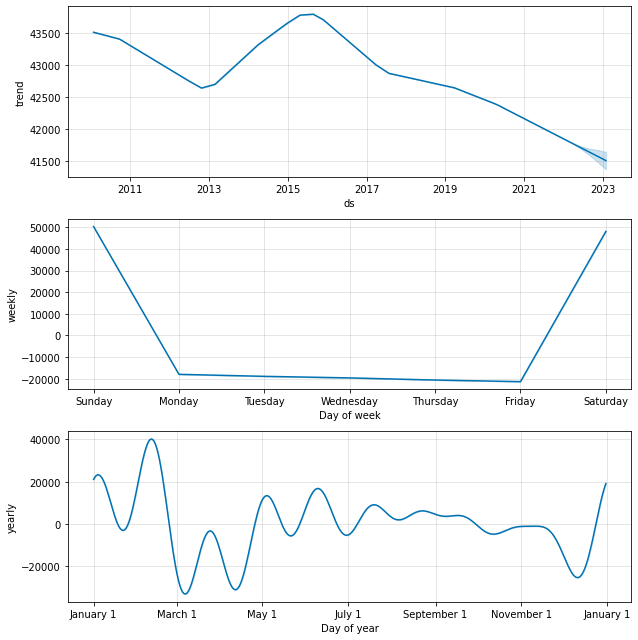

In [41]:
m_by_365_day, future_by_365_day, forecast_for_365_day, fig1, fig2 = future_preds(df_by_day,period=365)
forecast_for_365_day[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

## Step Three: Model Tuning

### Logistic Forecasting Growth

In [42]:
def future_preds_logistic(df,period,cap,growth):
    if growth == 'logistic':
        df['cap'] = cap
    m = Prophet(growth=growth)
    m.fit(df)
    future = m.make_future_dataframe(period) #period is in units of days
    future['cap'] = cap
    forecast = m.predict(future)
    fig1 = m.plot(forecast);
    fig2 = m.plot_components(forecast);
    return (m, future, forecast, fig1, fig2) 

11:29:18 - cmdstanpy - INFO - Chain [1] start processing
11:29:20 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
567,2022-05-04,26983.701272,-8302.198598,65141.321466
568,2022-05-05,25527.162131,-9169.444239,57545.679932
569,2022-05-06,23870.180596,-12147.495785,59365.204799
570,2022-05-07,-38035.461630,-72687.585533,-221.712813
571,2022-05-08,-16664.284832,-53456.759953,20542.892340


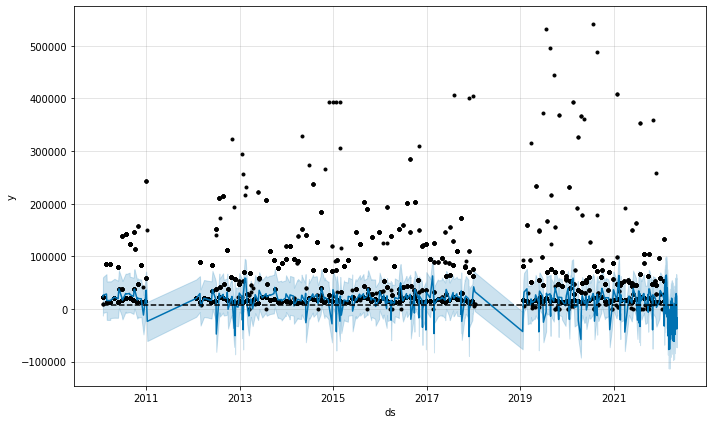

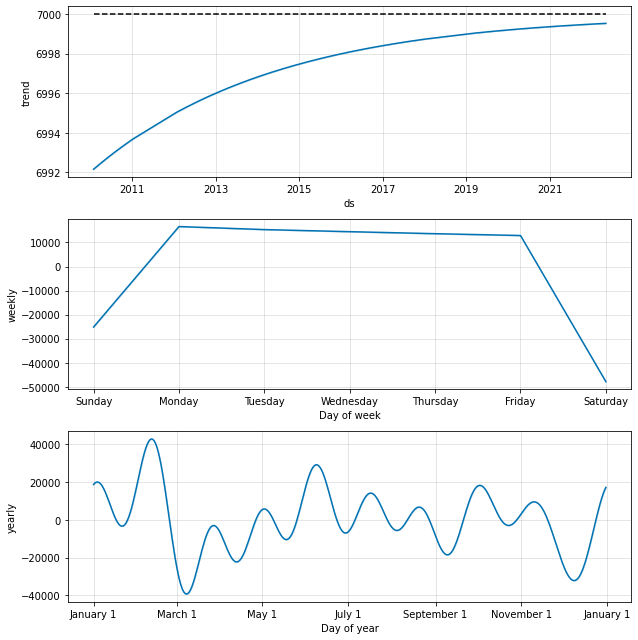

In [43]:
m_by_100_day_logistic, future_by_100_day_logistic, forecast_for_100_day_logistic, fig1, fig2 = future_preds_logistic(df_by_day,period=100,cap=7000,growth='logistic')
forecast_for_100_day_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

11:29:27 - cmdstanpy - INFO - Chain [1] start processing
11:29:27 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
567,2022-05-04,26983.701272,-8302.198598,65141.321466
568,2022-05-05,25527.162131,-9169.444239,57545.679932
569,2022-05-06,23870.180596,-12147.495785,59365.204799
570,2022-05-07,-38035.461630,-72687.585533,-221.712813
571,2022-05-08,-16664.284832,-53456.759953,20542.892340


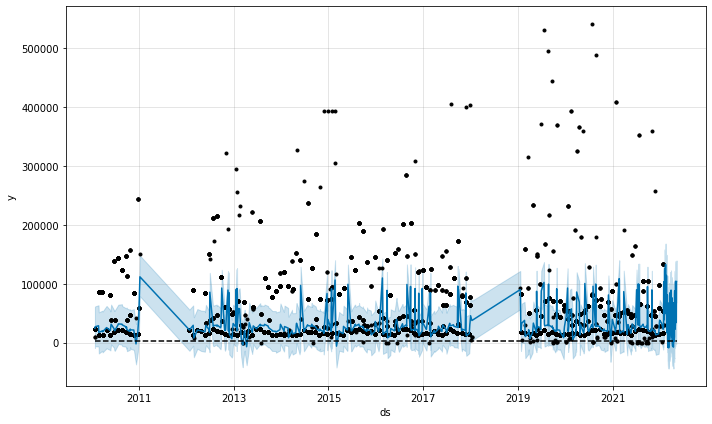

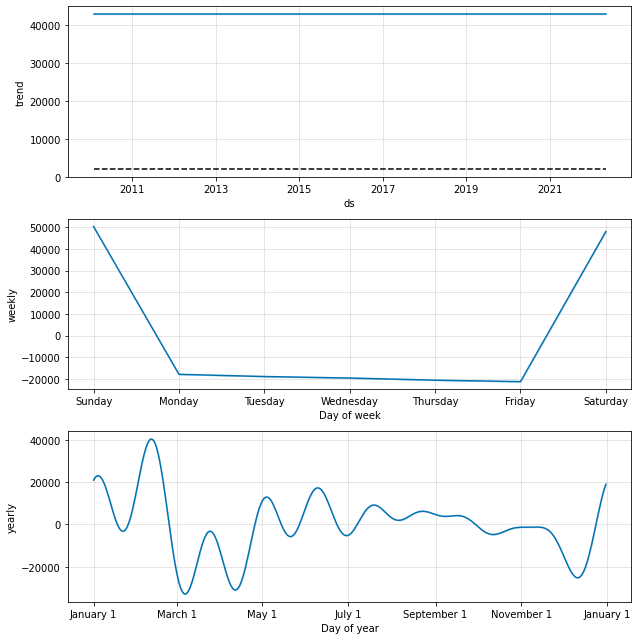

In [44]:
m_by_100_day_flat, future_by_100_day_flat, forecast_for_100_day_flat, fig1, fig2 = future_preds_logistic(df_by_day,period=100,cap=2000,growth='flat')
forecast_for_100_day_logistic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

### Seasonality 

In [45]:
def future_preds_seasonality(df,period,growth='linear',cap=None,daily_seasonality=False,weekly_seasonality=False,
                            yearly_seasonality=False,name=None,period_for_seasonality=None,fourier_order=None,
                            changepoint_prior_scale=1,n_changepoints=30):
    if growth == 'logistic':
        df['cap'] = cap                        
    m = Prophet(growth,daily_seasonality=daily_seasonality,weekly_seasonality=weekly_seasonality,
                yearly_seasonality=yearly_seasonality,
                changepoint_prior_scale=changepoint_prior_scale,
                n_changepoints=n_changepoints)
    m.add_seasonality(name,period_for_seasonality,fourier_order)
    m.add_country_holidays(country_name='US')
    m.fit(df)
    future = m.make_future_dataframe(period) #period is in units of days
    forecast = m.predict(future)
    fig1 = m.plot(forecast);
    fig2 = m.plot_components(forecast);
    return (forecast)

11:29:30 - cmdstanpy - INFO - Chain [1] start processing
11:29:34 - cmdstanpy - INFO - Chain [1] done processing


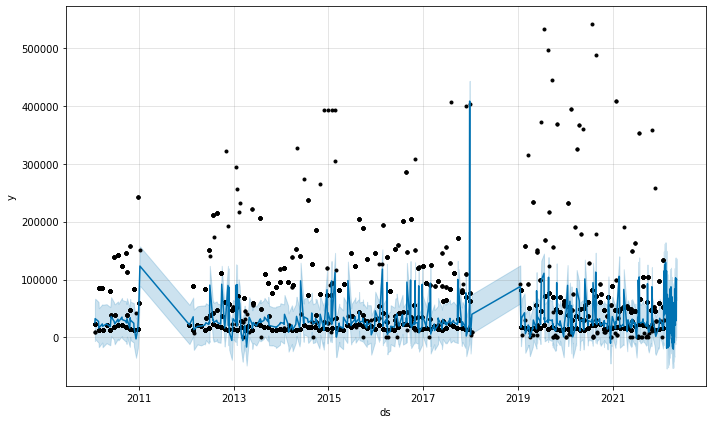

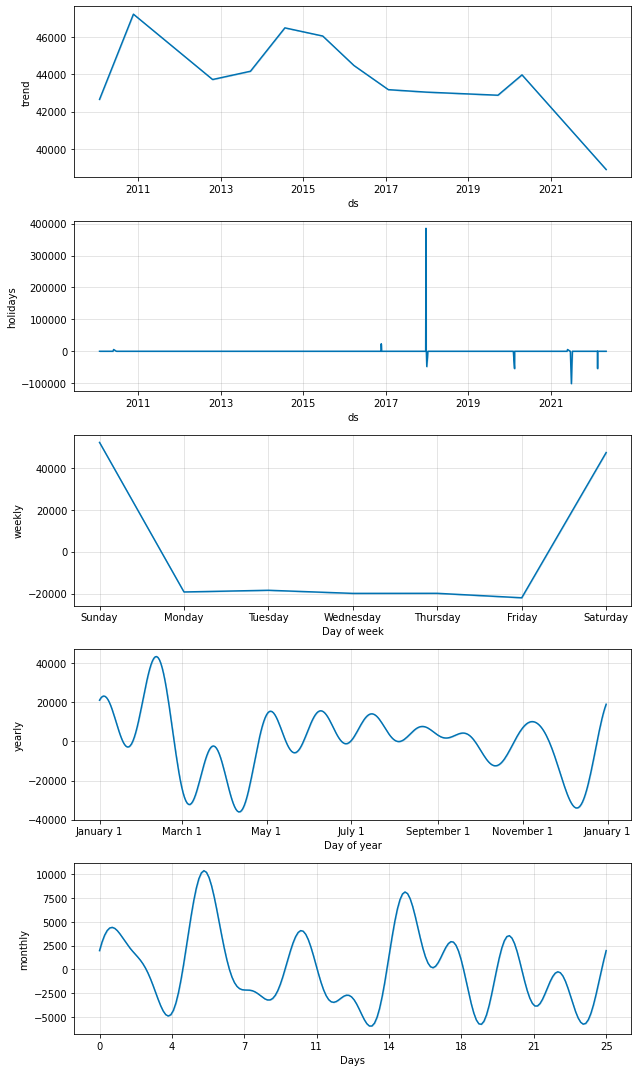

In [46]:
forecast_for_100_day_seasonality = future_preds_seasonality(df_by_day,period=100,weekly_seasonality=True,
                            yearly_seasonality=10,name='monthly',period_for_seasonality=25,fourier_order=10,
                            changepoint_prior_scale=1,n_changepoints=10)

11:29:36 - cmdstanpy - INFO - Chain [1] start processing
11:29:39 - cmdstanpy - INFO - Chain [1] done processing


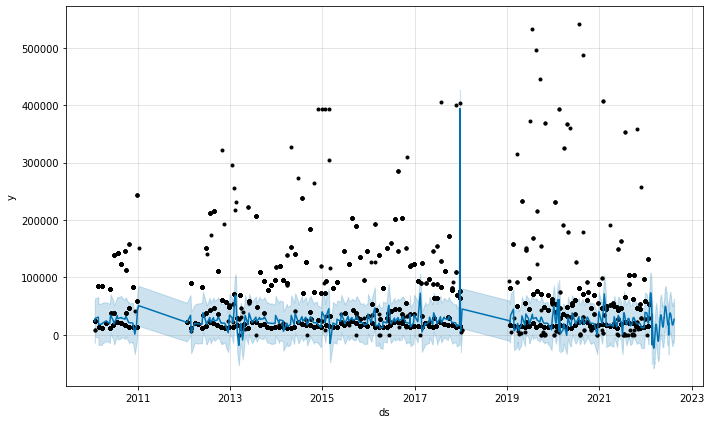

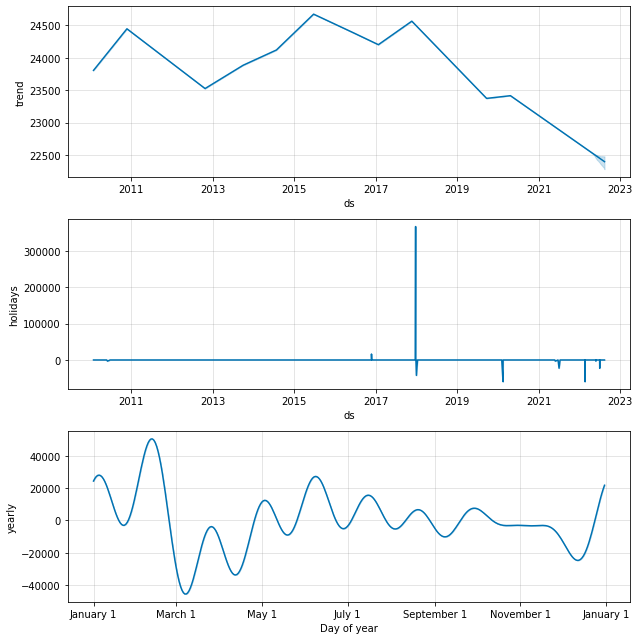

In [47]:
forecast_for_200_day_seasonality = future_preds_seasonality(df_by_day,period=200,weekly_seasonality=False,
                            yearly_seasonality=True,name='yearly',period_for_seasonality=25,fourier_order=10,
                            changepoint_prior_scale=1,n_changepoints=10)

In [48]:
def hyperparamter_tuning(df, param_grid, cap,
                        initial='730 days', period='180 days', horizon='365 days',
                        parallel='dask',growth='linear',seasonality=False,country_holidays=False,
                        name=None, period_for_seasonality=None, fourier_order=None):

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = []  # Store the RMSEs for each params here
    final_df_cv = pd.DataFrame()
    final_df_p = pd.DataFrame()

    if growth == 'logistic':
        df['cap'] = cap 

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params)

        if seasonality == True:
            m.add_seasonality(name,period_for_seasonality,fourier_order)
        if country_holidays == True:
            m.add_country_holidays(country_name='US')

        m.fit(df)  # Fit model with given params
        df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon, parallel=parallel)
        df_p = performance_metrics(df_cv, rolling_window=1)
        mapes.append(df_p['rmse'].values[0])
        final_df_cv = pd.concat([final_df_cv, df_cv])
        final_df_p = pd.concat([final_df_p, df_p])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = mapes

    best_params = all_params[np.argmin(mapes)]

    return(m, final_df_cv, final_df_p, tuning_results, best_params)

In [49]:
client = Client()  # connect to the cluster

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

m, df_cv, df_p, tuning_results, best_params = hyperparamter_tuning(df, param_grid, cap=9000,
                        initial='730 days', period='180 days', horizon='365 days',
                        parallel='dask',growth='logistic',seasonality=True,country_holidays=True,
                        name='yearly', period_for_seasonality=365, fourier_order=10)  

client.close()          

2022-12-25 11:29:41,733 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/n9/3mjn__fd1xd66lc1zh9nlj0h0000gp/T/dask-worker-space/worker-3r2rj7ig', purging
2022-12-25 11:29:41,734 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/n9/3mjn__fd1xd66lc1zh9nlj0h0000gp/T/dask-worker-space/worker-slmaer_l', purging
2022-12-25 11:29:41,735 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/n9/3mjn__fd1xd66lc1zh9nlj0h0000gp/T/dask-worker-space/worker-tpgor8gv', purging
2022-12-25 11:29:41,736 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/n9/3mjn__fd1xd66lc1zh9nlj0h0000gp/T/dask-worker-space/worker-lfjxidd5', purging
11:29:43 - cmdstanpy - INFO - Chain [1] start processing
11:29:45 - cmdstanpy - INFO - Chain [1] done processing
11:29:47 - cmdstanpy - INFO - Chain [1] start processing
11:29:47 - cmdstanpy - INFO - Chain [1] done processing
11:29:47 - cmdstanpy - INF

In [50]:
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}


In [51]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-03-26,76567.551490,-960.257954,155988.750318,47,2012-03-16
1,2012-03-26,76567.551490,-1658.276591,151904.053223,810,2012-03-16
2,2012-03-26,76567.551490,-5805.398992,151292.805392,8480,2012-03-16
3,2012-03-26,76567.551490,-2586.984087,156688.443376,86,2012-03-16
4,2012-03-26,76567.551490,1405.766925,155118.474294,33280,2012-03-16
...,...,...,...,...,...,...
36213,2022-01-26,24227.419851,-48714.700055,98405.774810,33600,2021-01-28
36214,2022-01-26,24227.419851,-46060.708202,96029.285313,29680,2021-01-28
36215,2022-01-26,24227.419851,-50986.750453,93706.951766,126680,2021-01-28
36216,2022-01-28,27579.764317,-43129.778739,100888.923402,36400,2021-01-28


In [52]:
df_p.sort_values('smape',ascending=False)

,horizon,mse,rmse,mae,mdape,smape,coverage
0,365 days,1.211133e+10,110051.509233,55409.327573,16.376177,1.496472,0.830968
0,365 days,1.424924e+10,119370.188299,57196.022804,16.525073,1.495666,0.835607
0,365 days,4.190122e+09,64731.149537,38979.434376,15.033497,1.480845,0.872826
0,365 days,4.306419e+09,65623.307652,36804.975255,14.327362,1.475530,0.894804
0,365 days,4.249479e+09,65188.031669,36797.407211,14.504828,1.471239,0.895715
0,365 days,4.253696e+09,65220.361759,36791.369237,14.439989,1.470999,0.895522
0,365 days,4.375201e+09,66145.303421,37256.380998,15.316711,1.467308,0.895825
0,365 days,4.305574e+09,65616.873203,37076.275926,15.294445,1.467192,0.898227
0,365 days,4.219871e+09,64960.535798,36804.903130,15.275935,1.466785,0.900602
0,365 days,3.965613e+09,62973.115902,34962.687303,14.193991,1.463653,0.910404


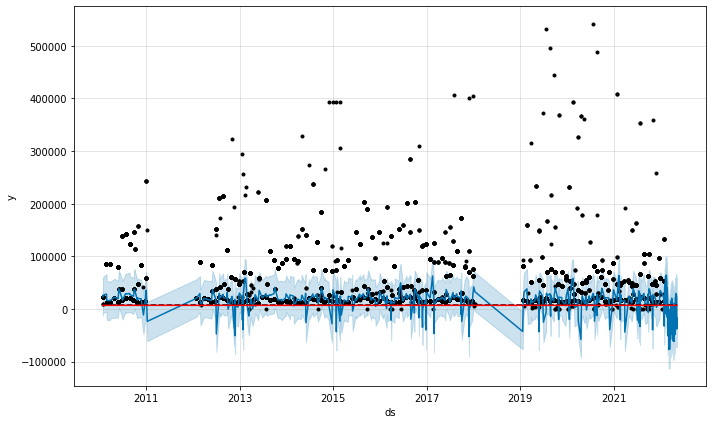

In [53]:
fig = m_by_100_day_logistic.plot(forecast_for_100_day_logistic)
a = add_changepoints_to_plot(fig.gca(), m_by_100_day_logistic, forecast_for_100_day_logistic)

## Step Four: Model Evaluation

In [54]:
client = Client()  # connect to the cluster
m = Prophet()
m.fit(df_by_year)
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel='dask')
df_p_by_year = performance_metrics(df_cv)
# df_p_by_year = pd.concat([df_p['horizon'],df_p['mape']],axis=1)
client.close()   

11:42:08 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing
11:43:02 - cmdstanpy - INFO - Chain [1] start processing
11:43:02 - cmdstanpy - INFO - Chain [1] start processing
11:43:02 - cmdstanpy - INFO - Chain [1] start processing
11:43:02 - cmdstanpy - INFO - Chain [1] start processing
11:43:06 - cmdstanpy - INFO - Chain [1] start processing
11:43:06 - cmdstanpy - INFO - Chain [1] start processing
11:43:07 - cmdstanpy - INFO - Chain [1] start processing
11:43:07 - cmdstanpy - INFO - Chain [1] start processing
11:43:07 - cmdstanpy - INFO - Chain [1] start processing
11:43:08 - cmdstanpy - INFO - Chain [1] start processing
11:43:08 - cmdstanpy - INFO - Chain [1] start processing
11:43:08 - cmdstanpy - INFO - Chain [1] start processing
11:43:08 - cmdstanpy - INFO - Chain [1] start processing
11:43:09 - cmdstanpy - INFO - Chain [1] start processing
11:43:10 - cmdstanpy - INFO - Chain [1] start processing
11:43:10 - cmdstanpy - INFO - Ch

In [55]:
client = Client()  # connect to the cluster
m = Prophet()
m.fit(df_by_month)
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel='dask')
df_p_by_month = performance_metrics(df_cv)
# df_p_by_month = pd.concat([df_p['horizon'],df_p['mape']],axis=1)
client.close()   

11:49:01 - cmdstanpy - INFO - Chain [1] start processing
11:49:16 - cmdstanpy - INFO - Chain [1] done processing
11:49:18 - cmdstanpy - INFO - Chain [1] start processing
11:49:18 - cmdstanpy - INFO - Chain [1] start processing
11:49:18 - cmdstanpy - INFO - Chain [1] start processing
11:49:18 - cmdstanpy - INFO - Chain [1] start processing
11:49:22 - cmdstanpy - INFO - Chain [1] start processing
11:49:22 - cmdstanpy - INFO - Chain [1] start processing
11:49:23 - cmdstanpy - INFO - Chain [1] start processing
11:49:24 - cmdstanpy - INFO - Chain [1] start processing
11:49:24 - cmdstanpy - INFO - Chain [1] start processing
11:49:24 - cmdstanpy - INFO - Chain [1] start processing
11:49:24 - cmdstanpy - INFO - Chain [1] start processing
11:49:24 - cmdstanpy - INFO - Chain [1] start processing
11:49:24 - cmdstanpy - INFO - Chain [1] start processing
11:49:25 - cmdstanpy - INFO - Chain [1] start processing
11:49:25 - cmdstanpy - INFO - Chain [1] start processing
11:49:25 - cmdstanpy - INFO - Ch

In [56]:
client = Client()  # connect to the cluster
m = Prophet()
m.fit(df_by_day)
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel='dask')
df_p_by_day = performance_metrics(df_cv)
# df_p_by_day = pd.concat([df_p['horizon'],df_p['smape']],axis=1)
client.close()   

11:53:20 - cmdstanpy - INFO - Chain [1] start processing
11:53:21 - cmdstanpy - INFO - Chain [1] done processing
11:53:23 - cmdstanpy - INFO - Chain [1] start processing
11:53:24 - cmdstanpy - INFO - Chain [1] start processing
11:53:24 - cmdstanpy - INFO - Chain [1] start processing
11:53:24 - cmdstanpy - INFO - Chain [1] start processing
11:53:25 - cmdstanpy - INFO - Chain [1] done processing
11:53:26 - cmdstanpy - INFO - Chain [1] done processing
11:53:26 - cmdstanpy - INFO - Chain [1] done processing
11:53:26 - cmdstanpy - INFO - Chain [1] done processing
11:53:27 - cmdstanpy - INFO - Chain [1] start processing
11:53:27 - cmdstanpy - INFO - Chain [1] start processing
11:53:27 - cmdstanpy - INFO - Chain [1] start processing
11:53:27 - cmdstanpy - INFO - Chain [1] start processing
11:53:27 - cmdstanpy - INFO - Chain [1] done processing
11:53:28 - cmdstanpy - INFO - Chain [1] start processing
11:53:28 - cmdstanpy - INFO - Chain [1] start processing
11:53:28 - cmdstanpy - INFO - Chain [

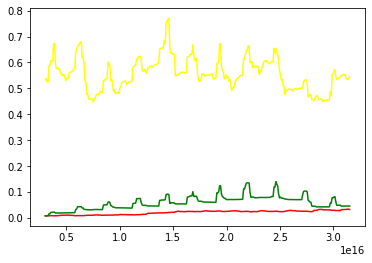

In [57]:
plt.plot(df_p_by_year['horizon'],df_p_by_year['mape'],color="red")
plt.plot(df_p_by_month['horizon'],df_p_by_month['mape'],color="green")
plt.plot(df_p_by_day['horizon'],df_p_by_day['smape'],color="yellow")

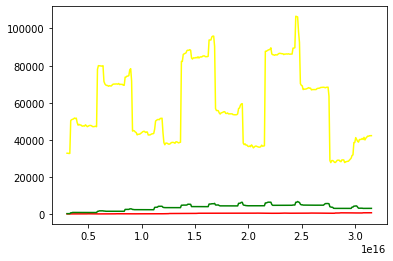

In [58]:
plt.plot(df_p_by_year['horizon'],df_p_by_year['rmse'],color="red")
plt.plot(df_p_by_month['horizon'],df_p_by_month['rmse'],color="green")
plt.plot(df_p_by_day['horizon'],df_p_by_day['rmse'],color="yellow")

In [59]:
df_p

,horizon,mse,rmse,mae,mdape,smape,coverage
0,365 days,3.284361e+09,57309.341718,31901.124369,14.165607,1.453259,0.928323
0,365 days,4.040569e+09,63565.470685,35106.611183,14.068954,1.463630,0.910652
0,365 days,3.256459e+09,57065.391979,31366.480236,13.360279,1.462981,0.935888
0,365 days,3.965613e+09,62973.115902,34962.687303,14.193991,1.463653,0.910404
0,365 days,3.426242e+09,58534.110946,33366.758225,15.162066,1.456087,0.923381
0,365 days,4.219871e+09,64960.535798,36804.903130,15.275935,1.466785,0.900602
0,365 days,4.375201e+09,66145.303421,37256.380998,15.316711,1.467308,0.895825
0,365 days,4.305574e+09,65616.873203,37076.275926,15.294445,1.467192,0.898227
0,365 days,3.394857e+09,58265.402531,32810.029434,14.588386,1.454253,0.924568
0,365 days,4.306419e+09,65623.307652,36804.975255,14.327362,1.475530,0.894804


## Step Five: Predictions by Borough

In [60]:
df2['Borough'].unique()

array(['BRONX', 'BROOKLYN', 'QUEENS', 'MANHATTAN', 'STATEN ISLAND'],
      dtype=object)

In [61]:
df2['avg_by_year'] = df2.groupby('Borough')['y'].transform('mean')

KeyError: 'Column not found: y'